# Install Library

[RDKit ](https://github.com/rdkit/rdkit)

[DGL](https://github.com/dmlc/dgl/)

[DGL-LifeSci](https://github.com/awslabs/dgl-lifesci)

In [ ]:
!pip install --pre dgl -f https://data.dgl.ai/wheels/cu113/repo.html
!pip install --pre dglgo -f https://data.dgl.ai/wheels-test/repo.html

In [ ]:
%%capture
!pip install rdkit-pypi
!pip install dgllife

# Import Library

In [1]:
import os

os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES']='-1'
os.environ['TF_CUDNN_USE_AUTOTUNE'] ='0'

import dgl 
import sys
import random
import statistics
import cv2
import torchvision
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim

from numpy import array
from numpy import argmax
from tensorflow.keras.utils import to_categorical
from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, AttentiveFPAtomFeaturizer
from tqdm.notebook import tqdm, trange
from sklearn.model_selection import train_test_split
from dgllife.model import MLPPredictor

from utils.general import DATASET, get_dataset, separate_active_and_inactive_data, get_embedding_vector_class, count_lablel,data_generator
from utils.gcn_pre_trained import get_muv_model
from model.heterogeneous_siamese_muv import siamese_model_attentiveFp_muv, siamese_model_Canonical_muv

random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data

In [2]:
cache_path='./muv_dglgraph.bin'

df = get_dataset("muv")

ids = df['mol_id'].tolist()
load_full = False

df = df.drop(columns=['mol_id'])

In [3]:
muv_tasks = df.columns.values[:17].tolist()
muv_tasks_test = muv_tasks[12:17]
train_task, valid_task = train_test_split(muv_tasks, test_size=0.25 , shuffle= False)

In [4]:
one = []
zero = []
nan = []
 
for task in muv_tasks:
    a = list(df[task].value_counts(dropna=False).to_dict().values())
    zero.append(a[0])
    nan.append(a[1])
    one.append(a[2])
    print(task ,"one:" ,a[2] ," zero:", a[0], " NAN:",a[1])


MUV-466 one: 27  zero: 78246  NAN: 14814
MUV-548 one: 29  zero: 78353  NAN: 14705
MUV-600 one: 30  zero: 78359  NAN: 14698
MUV-644 one: 30  zero: 78464  NAN: 14593
MUV-652 one: 29  zero: 78185  NAN: 14873
MUV-689 one: 29  zero: 78486  NAN: 14572
MUV-692 one: 30  zero: 78443  NAN: 14614
MUV-712 one: 28  zero: 78676  NAN: 14383
MUV-713 one: 29  zero: 78251  NAN: 14807
MUV-733 one: 28  zero: 78405  NAN: 14654
MUV-737 one: 29  zero: 78396  NAN: 14662
MUV-810 one: 29  zero: 78443  NAN: 14615
MUV-832 one: 30  zero: 78420  NAN: 14637
MUV-846 one: 30  zero: 78376  NAN: 14681
MUV-852 one: 29  zero: 78436  NAN: 14622
MUV-858 one: 29  zero: 78313  NAN: 14745
MUV-859 one: 24  zero: 78341  NAN: 14722


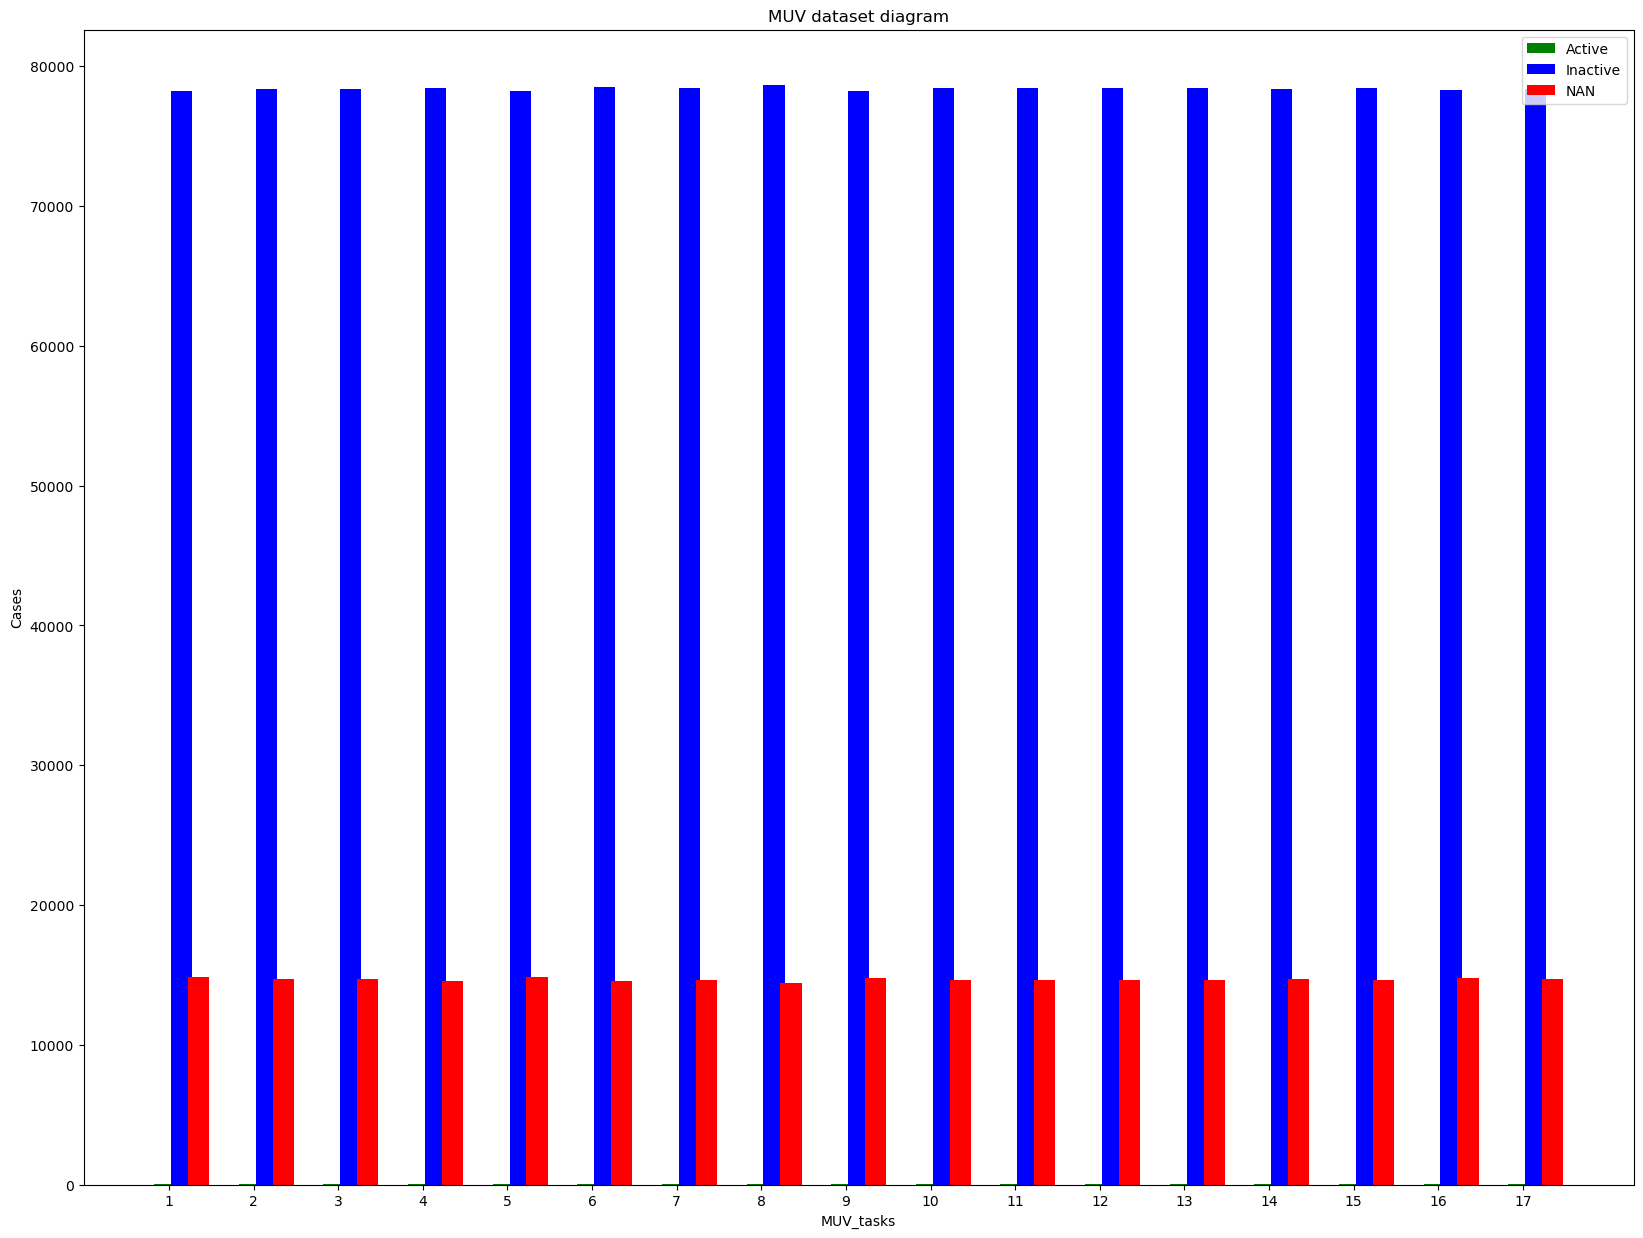

In [5]:
# Importing the matplotlib library
import numpy as np
import matplotlib.pyplot as plt
# Declaring the figure or the plot (y, x) or (width, height)
plt.figure(figsize=[20, 15])

X = np.arange(1,len(muv_tasks)+1)
plt.bar(X + 0.2, one, color = 'g', width = 0.25)
plt.bar(X + 0.4, zero, color = 'b', width = 0.25)
plt.bar(X + 0.6, nan, color = 'r', width = 0.25)

# Creating the legend of the bars in the plot
plt.legend(['Active' , 'Inactive' ,'NAN'])
# Overiding the x axis with the country names
plt.xticks([i + 0.25 for i in range(1,18)], X)
# Giving the tilte for the plot
plt.title("MUV dataset diagram")
# Namimg the x and y axis
plt.xlabel('MUV_tasks')
plt.ylabel('Cases')
# Saving the plot as a 'png'
plt.savefig('4BarPlot.png')
# Displaying the bar plot
plt.show()

# Required functions

In [7]:
from dgllife.model import MLPPredictor

def create_dataset_with_gcn(dataset, class_embed_vector, GCN, tasks, numberTask):

    created_data = []
    data = np.arange(len(tasks))
    onehot_encoded = to_categorical(data)

    for i, data in enumerate(dataset):
        smiles, g, label, mask = data
        g = g.to(device)
        g = dgl.add_self_loop(g)
        graph_feats = g.ndata.pop('h')
        embbed = GCN(g, graph_feats)
        embbed = embbed.to('cpu')
        embbed = embbed.detach().numpy()
        a = ( embbed, onehot_encoded[numberTask], class_embed_vector[numberTask], label, tasks[numberTask])
        created_data.append(a)
    print('Data created!!')
    return created_data 


def create_meta_data_gcn(GCN, dataset, class_embed_vector, train_task_size, tasks):
    
    train_data= []
    valid_data = []
    data = np.arange(len(tasks))
    onehot_encoded = to_categorical(data)
    
    for numberTask , datas in enumerate(dataset):
        
        for j, data in enumerate(datas):
            
            smiles, g, label, mask = data
            
            g = g.to(device)
            g = dgl.add_self_loop(g)
            graph_feats = g.ndata.pop('h')
            embbed = GCN(g, graph_feats)
            embbed = embbed.to('cpu')
            embbed = embbed.detach().numpy()
            a = (smiles, embbed, onehot_encoded[numberTask], class_embed_vector[numberTask], label[0], tasks[numberTask])

            
            if numberTask < train_task_size :
                train_data.append(a)
            else:
                valid_data.append(a)

    print('Data created!!')            
    return train_data, valid_data 

# Calculation of embedded vectors for each class 

In [8]:
df_positive, df_negative = separate_active_and_inactive_data(df, muv_tasks)

for i,d in enumerate(zip(df_positive,df_negative)):
    print(f'{muv_tasks[i]}=> positive: {len(d[0])} - negative: {len(d[1])}')

MUV-466=> positive: 27 - negative: 14814
MUV-548=> positive: 29 - negative: 14705
MUV-600=> positive: 30 - negative: 14698
MUV-644=> positive: 30 - negative: 14593
MUV-652=> positive: 29 - negative: 14873
MUV-689=> positive: 29 - negative: 14572
MUV-692=> positive: 30 - negative: 14614
MUV-712=> positive: 28 - negative: 14383
MUV-713=> positive: 29 - negative: 14807
MUV-733=> positive: 28 - negative: 14654
MUV-737=> positive: 29 - negative: 14662
MUV-810=> positive: 29 - negative: 14615
MUV-832=> positive: 30 - negative: 14637
MUV-846=> positive: 30 - negative: 14681
MUV-852=> positive: 29 - negative: 14622
MUV-858=> positive: 29 - negative: 14745
MUV-859=> positive: 24 - negative: 14722


In [9]:
dataset_positive = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_positive]
dataset_negative = [DATASET(d, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path) for d in df_negative]

Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing dgl graphs from scratch...
Processing molecule 1000/14814
Processing molecule 2000/14814
Processing molecule 3000/14814
Processing molecule 4000/14814
Processing molecule 5000/14814
Processing molecule 6000/14814
Processing molecule 7000/14814
Processing molecule 8000/14814
Processing molecule 9000/14814
Processing molecule 10000/14814
Proce

Processing molecule 13000/14745
Processing molecule 14000/14745
Processing dgl graphs from scratch...
Processing molecule 1000/14722
Processing molecule 2000/14722
Processing molecule 3000/14722
Processing molecule 4000/14722
Processing molecule 5000/14722
Processing molecule 6000/14722
Processing molecule 7000/14722
Processing molecule 8000/14722
Processing molecule 9000/14722
Processing molecule 10000/14722
Processing molecule 11000/14722
Processing molecule 12000/14722
Processing molecule 13000/14722
Processing molecule 14000/14722


In [10]:
embed_class_muv = get_embedding_vector_class(dataset_positive, dataset_negative, radius=2, size = 512)

class vector created!!


# Bioactivity class-based strategy (Meta-Learning) with BioAct-Het

## Meta-Learning with BioAct-Het and AttentiveFP GCN 

### Siamea model

In [73]:
model_name = 'GCN_attentivefp_MUV'
gcn_model = get_muv_model(model_name)
gcn_model.eval()
gcn_model = gcn_model.to(device)

Pretrained model loaded


In [74]:
data_ds = []
cache_path='./muv_dglgraph.bin'
for i, task in  enumerate(muv_tasks):
    a = df[['smiles' , task]]
    a = a.dropna()
    ds = DATASET(a, smiles_to_bigraph, AttentiveFPAtomFeaturizer(), cache_file_path = cache_path)
    data_ds.append(ds)

Processing dgl graphs from scratch...
Processing molecule 1000/14841
Processing molecule 2000/14841
Processing molecule 3000/14841
Processing molecule 4000/14841
Processing molecule 5000/14841
Processing molecule 6000/14841
Processing molecule 7000/14841
Processing molecule 8000/14841
Processing molecule 9000/14841
Processing molecule 10000/14841
Processing molecule 11000/14841
Processing molecule 12000/14841
Processing molecule 13000/14841
Processing molecule 14000/14841
Processing dgl graphs from scratch...
Processing molecule 1000/14734
Processing molecule 2000/14734
Processing molecule 3000/14734
Processing molecule 4000/14734
Processing molecule 5000/14734
Processing molecule 6000/14734
Processing molecule 7000/14734
Processing molecule 8000/14734
Processing molecule 9000/14734
Processing molecule 10000/14734
Processing molecule 11000/14734
Processing molecule 12000/14734
Processing molecule 13000/14734
Processing molecule 14000/14734
Processing dgl graphs from scratch...
Processi

In [75]:
train_dataset, valid_dataset = create_meta_data_gcn (gcn_model, data_ds, embed_class_muv, 12, muv_tasks)

Data created!!


In [76]:
print(f'{len(train_dataset)}-{len(valid_dataset)}')

176337-73549


In [77]:
label_pos , label_neg, _ , _  = count_lablel(train_dataset)
print(f'train positive label: {label_pos} - train negative label: {label_neg}')

label_pos , label_neg, _ , _ = count_lablel(valid_dataset)
print(f'Test positive label: {label_pos} - Test negative label: {label_neg}')

train positive label: 347 - train negative label: 175990
Test positive label: 142 - Test negative label: 73407


In [86]:
train_ds = up_and_down_Samplenig(train_dataset, sacale_upsampling = 2 , scale_downsampling = 0.99)

label_pos , label_neg , _ , _ = count_lablel(train_ds)
print(f'up and down sampling => train positive label: {label_pos} - train negative label: {label_neg}')

up and down sampling => train positive label: 87791 - train negative label: 174230


### Training algorithm

In [88]:
# models = [siamese_net for task in sider_tasks_final]
Epoch_S = 15
l = []
r = []
lbls = []
for i , data in enumerate(train_ds):
    smile, embbed_drug, onehot_task, embbed_task, lbl, task_name = data
    l.append(embbed_drug[0])
    r.append(embbed_task)
    lbls.append(lbl.tolist())

l = np.array(l).reshape(-1,128,1)
r = np.array(r).reshape(-1,512,1)
lbls=np.array(lbls)

history = History()

siamese_net = siamese_model_attentiveFp_muv()

P = siamese_net.fit([l, r], lbls, epochs = Epoch_S, shuffle=True, batch_size=128, callbacks=[history])

for j in range(1000):
    C=1
    Before = int(P.history['accuracy'][-1]*100)
    for i in range(2,Epoch_S+1):
        if  int(P.history['accuracy'][-i]*100)== Before:
            C=C+1
        else:
            C=1
        Before=int(P.history['accuracy'][-i]*100)
        print(Before)
    if C==Epoch_S:
        break
    P = siamese_net.fit([l, r], lbls, epochs = Epoch_S, shuffle=True, batch_size=128, callbacks=history)
print(j+1)


Epoch 1/15
2048/2048 [==============================] - 22s 11ms/step - loss: 0.6376 - accuracy: 0.6638 - mae: 0.4437 - mse: 0.2226 - auc_8: 0.5379
Epoch 2/15
2048/2048 [==============================] - 22s 11ms/step - loss: 0.6005 - accuracy: 0.6696 - mae: 0.4144 - mse: 0.2070 - auc_8: 0.6642
Epoch 3/15
2048/2048 [==============================] - 23s 11ms/step - loss: 0.5875 - accuracy: 0.6924 - mae: 0.4036 - mse: 0.2012 - auc_8: 0.6872
Epoch 4/15
2048/2048 [==============================] - 29s 14ms/step - loss: 0.5785 - accuracy: 0.7010 - mae: 0.3951 - mse: 0.1973 - auc_8: 0.7003
Epoch 5/15
2048/2048 [==============================] - 29s 14ms/step - loss: 0.5726 - accuracy: 0.7049 - mae: 0.3904 - mse: 0.1950 - auc_8: 0.7090
Epoch 6/15
2048/2048 [==============================] - 29s 14ms/step - loss: 0.5680 - accuracy: 0.7076 - mae: 0.3871 - mse: 0.1933 - auc_8: 0.7157
Epoch 7/15
2048/2048 [==============================] - 28s 14ms/step - loss: 0.5648 - accuracy: 0.7091 - mae: 0

### Model evaluation

In [89]:
valid_ds = {}

for i, task in enumerate(muv_tasks_test):
    temp = []
    for j , data in enumerate(valid_dataset):
        smiles, embbed_drug, onehot_task, embbed_task, lbl, task_name = data
        if task ==  task_name:
            temp.append(data)
    
    valid_ds[task] = temp


In [90]:
task_scores = [muv_tasks_test for muv_tasks_test in range(len(muv_tasks_test))]

for i, task in enumerate(muv_tasks_test):
    print(task,": ")

    y_test = []
    l_val = []
    r_val = []
    lbls_valid = []
    for data in valid_ds[task]:
       
        smiles, embbed_drug, onehot_task, embbed_task, lbl, task_name = data
        l_val.append(embbed_drug[0])
        r_val.append(embbed_task)
        lbls_valid.append(lbl)
            
    l1 = np.asarray(l_val)
    r1 = np.asarray(r_val)
    lbls_valid = np.asarray(lbls_valid)

    score = siamese_net.evaluate([l1,r1],lbls_valid)
 
    result =(score[1], score[4])
    task_scores[i] = task,result

MUV-832 : 
459/459 [==============================] - 1s 2ms/step - loss: 0.3388 - accuracy: 0.8936 - mae: 0.2602 - mse: 0.1011 - auc_8: 0.7056
MUV-846 : 
460/460 [==============================] - 1s 2ms/step - loss: 0.4206 - accuracy: 0.8183 - mae: 0.3091 - mse: 0.1332 - auc_8: 0.7709
MUV-852 : 
458/458 [==============================] - 1s 2ms/step - loss: 0.4146 - accuracy: 0.8176 - mae: 0.3042 - mse: 0.1318 - auc_8: 0.7391
MUV-858 : 
462/462 [==============================] - 1s 2ms/step - loss: 0.3331 - accuracy: 0.9028 - mae: 0.2586 - mse: 0.0979 - auc_8: 0.6079
MUV-859 : 
461/461 [==============================] - 1s 2ms/step - loss: 0.3170 - accuracy: 0.9179 - mae: 0.2455 - mse: 0.0923 - auc_8: 0.4527


## Meta-Learning with BioAct-Het and Canonical GCN

### Siamea model

In [11]:
model_GCN = 'GCN_canonical_MUV'
gcn_model = get_muv_model(model_GCN)
gcn_model.eval()
gcn_model = gcn_model.to(device)

Pretrained model loaded


In [14]:
data_ds = []
for i, task in  enumerate(muv_tasks):
    a = df[['smiles' , task]]
    a = a.dropna()
    ds = DATASET(a, smiles_to_bigraph, CanonicalAtomFeaturizer(), cache_file_path = cache_path)
    data_ds.append(ds)

Processing dgl graphs from scratch...
Processing molecule 1000/14841
Processing molecule 2000/14841
Processing molecule 3000/14841
Processing molecule 4000/14841
Processing molecule 5000/14841
Processing molecule 6000/14841
Processing molecule 7000/14841
Processing molecule 8000/14841
Processing molecule 9000/14841
Processing molecule 10000/14841
Processing molecule 11000/14841
Processing molecule 12000/14841
Processing molecule 13000/14841
Processing molecule 14000/14841
Processing dgl graphs from scratch...
Processing molecule 1000/14734
Processing molecule 2000/14734
Processing molecule 3000/14734
Processing molecule 4000/14734
Processing molecule 5000/14734
Processing molecule 6000/14734
Processing molecule 7000/14734
Processing molecule 8000/14734
Processing molecule 9000/14734
Processing molecule 10000/14734
Processing molecule 11000/14734
Processing molecule 12000/14734
Processing molecule 13000/14734
Processing molecule 14000/14734
Processing dgl graphs from scratch...
Processi

In [15]:
train_dataset, valid_dataset = create_meta_data_gcn (gcn_model, data_ds, embed_class_muv, 12, muv_tasks)

Data created!!


In [16]:
print(f'{len(train_dataset)}-{len(valid_dataset)}')

176337-73549


In [17]:
label_pos , label_neg, _ , _  = count_lablel(train_dataset)
print(f'train positive label: {label_pos} - train negative label: {label_neg}')

label_pos , label_neg, _ , _ = count_lablel(valid_dataset)
print(f'Test positive label: {label_pos} - Test negative label: {label_neg}')

train positive label: 347 - train negative label: 175990
Test positive label: 142 - Test negative label: 73407


In [18]:
train_ds = up_and_down_Samplenig(train_dataset, sacale_upsampling = 2 , scale_downsampling = 0.99)

label_pos , label_neg , _ , _ = count_lablel(train_ds)
print(f'up and down sampling => train positive label: {label_pos} - train negative label: {label_neg}')

up and down sampling => train positive label: 87791 - train negative label: 174230


### Training algorithm

In [20]:
# models = [siamese_net for task in sider_tasks_final]
Epoch_S = 15
l = []
r = []
lbls = []
for i , data in enumerate(train_ds):
    smile, embbed_drug, onehot_task, embbed_task, lbl, task_name = data
    l.append(embbed_drug[0])
    r.append(embbed_task)
    lbls.append(lbl.tolist())

l = np.array(l).reshape(-1,128,1)
r = np.array(r).reshape(-1,512,1)
lbls=np.array(lbls)

history = History()

siamese_net = siamese_model_Canonical_muv()

P = siamese_net.fit([l, r], lbls, epochs = Epoch_S, shuffle=True, batch_size=128, callbacks=[history])

for j in range(1000):
    C=1
    Before = int(P.history['accuracy'][-1]*100)
    for i in range(2,Epoch_S+1):
        if  int(P.history['accuracy'][-i]*100)== Before:
            C=C+1
        else:
            C=1
        Before=int(P.history['accuracy'][-i]*100)
        print(Before)
    if C==Epoch_S:
        break
    P = siamese_net.fit([l, r], lbls, epochs = Epoch_S, shuffle=True, batch_size=128, callbacks=history)
print(j+1)


Epoch 1/15
2048/2048 [==============================] - 8s 4ms/step - loss: 0.6156 - accuracy: 0.6699 - mae: 0.4251 - mse: 0.2132 - auc: 0.6240
Epoch 2/15
2048/2048 [==============================] - 8s 4ms/step - loss: 0.5883 - accuracy: 0.6881 - mae: 0.4052 - mse: 0.2025 - auc: 0.6773
Epoch 3/15
2048/2048 [==============================] - 8s 4ms/step - loss: 0.5748 - accuracy: 0.6953 - mae: 0.3948 - mse: 0.1971 - auc: 0.7029
Epoch 4/15
2048/2048 [==============================] - 8s 4ms/step - loss: 0.5632 - accuracy: 0.7044 - mae: 0.3860 - mse: 0.1926 - auc: 0.7206
Epoch 5/15
2048/2048 [==============================] - 8s 4ms/step - loss: 0.5539 - accuracy: 0.7108 - mae: 0.3790 - mse: 0.1892 - auc: 0.7331
Epoch 6/15
2048/2048 [==============================] - 8s 4ms/step - loss: 0.5450 - accuracy: 0.7166 - mae: 0.3722 - mse: 0.1858 - auc: 0.7452
Epoch 7/15
2048/2048 [==============================] - 8s 4ms/step - loss: 0.5400 - accuracy: 0.7203 - mae: 0.3684 - mse: 0.1840 - auc:

2048/2048 [==============================] - 7s 4ms/step - loss: 0.3977 - accuracy: 0.8010 - mae: 0.2636 - mse: 0.1319 - auc: 0.8815
Epoch 5/15
2048/2048 [==============================] - 7s 4ms/step - loss: 0.3982 - accuracy: 0.8003 - mae: 0.2640 - mse: 0.1319 - auc: 0.8813
Epoch 6/15
2048/2048 [==============================] - 8s 4ms/step - loss: 0.3952 - accuracy: 0.8031 - mae: 0.2617 - mse: 0.1308 - auc: 0.8835
Epoch 7/15
2048/2048 [==============================] - 7s 4ms/step - loss: 0.4017 - accuracy: 0.7988 - mae: 0.2657 - mse: 0.1330 - auc: 0.8794
Epoch 8/15
2048/2048 [==============================] - 7s 4ms/step - loss: 0.3992 - accuracy: 0.8001 - mae: 0.2644 - mse: 0.1322 - auc: 0.8809
Epoch 9/15
2048/2048 [==============================] - 7s 4ms/step - loss: 0.3981 - accuracy: 0.8010 - mae: 0.2638 - mse: 0.1318 - auc: 0.8815
Epoch 10/15
2048/2048 [==============================] - 7s 4ms/step - loss: 0.3954 - accuracy: 0.8018 - mae: 0.2618 - mse: 0.1308 - auc: 0.8833
Ep

### Model evaluation

In [21]:
valid_ds = {}

for i, task in enumerate(muv_tasks_test):
    temp = []
    for j , data in enumerate(valid_dataset):
        smiles, embbed_drug, onehot_task, embbed_task, lbl, task_name = data
        if task ==  task_name:
            temp.append(data)
    
    valid_ds[task] = temp


In [22]:
task_scores = [muv_tasks_test for muv_tasks_test in range(len(muv_tasks_test))]

for i, task in enumerate(muv_tasks_test):
    print(task,": ")

    y_test = []
    l_val = []
    r_val = []
    lbls_valid = []
    for data in valid_ds[task]:
       
        smiles, embbed_drug, onehot_task, embbed_task, lbl, task_name = data
        l_val.append(embbed_drug[0])
        r_val.append(embbed_task)
        lbls_valid.append(lbl)
            
    l1 = np.asarray(l_val)
    r1 = np.asarray(r_val)
    lbls_valid = np.asarray(lbls_valid)

    score = siamese_net.evaluate([l1,r1],lbls_valid)
 
    result =(score[1], score[4])
    task_scores[i] = task,result

MUV-832 : 
459/459 [==============================] - 0s 613us/step - loss: 0.2207 - accuracy: 0.8973 - mae: 0.1614 - mse: 0.0692 - auc: 0.6220
MUV-846 : 
460/460 [==============================] - 0s 601us/step - loss: 0.2448 - accuracy: 0.8749 - mae: 0.1776 - mse: 0.0789 - auc: 0.7106
MUV-852 : 
458/458 [==============================] - 0s 594us/step - loss: 0.2494 - accuracy: 0.8743 - mae: 0.1807 - mse: 0.0801 - auc: 0.6196
MUV-858 : 
462/462 [==============================] - 0s 596us/step - loss: 0.2137 - accuracy: 0.9029 - mae: 0.1566 - mse: 0.0660 - auc: 0.6450
MUV-859 : 
461/461 [==============================] - 0s 593us/step - loss: 0.2095 - accuracy: 0.9080 - mae: 0.1518 - mse: 0.0641 - auc: 0.4993
